# Welcome

This notebook serves as an example to how we can find rat runs through neighbourhoods. Any issues, please contact me at b8008458@newcastle.ac.uk!

We begin with importing the necessary libraries. There should be a .yml file on the GitHub repository which can be used to set up the correct environment. We also update OSMNx to ensure all the OSM tags we need are avaiable and ready. 

In [1]:
# Library imports
import geopandas as gpd
import osmnx as ox
import networkx as nx
import momepy
from shapely import Polygon
import matplotlib.pyplot as plt
import folium
import pandas as pd
import random
import overpy
import math
from shapely.geometry import LineString
from itertools import count
from shapely.geometry import Point
import requests
from shapely.geometry import MultiPolygon
from collections import Counter

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# update osmnx settings
useful_tags_ways = ox.settings.useful_tags_way + ['cycleway'] + ['bicycle'] + ['motor_vehicle'] + ['railway'] + ['tunnel'] + ['barrier'] + ['bus'] + ['access'] + ['oneway'] + ['oneway:bicycle'] + ['covered'] + ['waterway']
ox.config(use_cache=True, 
          log_console=True,
          useful_tags_way=useful_tags_ways
          )

C:\Users\b8008458\AppData\Local\Temp\ipykernel_1776\305956182.py:3: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True,


This project mostly uses OpenStreetMap data. We access this using OSMNx

Now we set the location of our example area. Feel free to try your own place

In [3]:
# set place
place = "City of Chester, United Kingdom"

We can now get all of the bounding features for our neighbourhoods. This covers railways, rivers, busy bus routes, roads (based on road type) and landuse. A more detailed example of this can be found in the "boundary_example.ipynb" notebook on GitHub.

In [4]:
# boundary

boundary = ox.geocode_to_gdf(place)
boundary = boundary.to_crs('EPSG:27700')

# buffer boundary to ensure clips include riverlines which may act as borders between geographies
boundary_buffered = boundary.buffer(50)

In [5]:
## get streets

drive_g = ox.graph_from_place(place, network_type='drive')

# convert to a gdf
gdf = ox.graph_to_gdfs(drive_g, nodes=False, edges=True)
gdf_nodes = ox.graph_to_gdfs(drive_g, nodes=True, edges=False)

# set crs
gdf = gdf.to_crs(27700)
gdf_nodes = gdf_nodes.to_crs(27700)

# Find "boundary" roads
boundary_roads = gdf.loc[((gdf['highway'] == 'trunk') |
                        (gdf['highway'] == 'trunk_link') |
                        (gdf['highway'] == 'motorway') |
                        (gdf['highway'] == 'motorway_link') |
                        (gdf['highway'] == 'primary') |
                        (gdf['highway'] == 'primary_link') |
                        (gdf['highway'] == 'secondary') |
                        (gdf['highway'] == 'secondary_link') |
                        (gdf['highway'] == 'tertiary') |
                        (gdf['highway'] == 'tertiary_link') |
                        # speeds
                        (gdf['maxspeed'] == '60 mph') | 
                        (gdf['maxspeed'] == '70 mph') |
                        (gdf['maxspeed'] == '40 mph') |
                        (gdf['maxspeed'] == ('20 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '50 mph')) |
                        (gdf['maxspeed'] == ('40 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('60 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('50 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('20 mph', '60 mph')) |
                        (gdf['maxspeed'] == ('70 mph', '40 mph')) |
                        (gdf['maxspeed'] == ('30 mph', '70 mph')) |
                        # combined queries
                        ((gdf['highway'] == 'residential') & (gdf['maxspeed'] == '30 mph'))
                        )]


# create a tiny buffer around the boundary roads
boundary_roads_buffer = boundary_roads.buffer(1)

# reset buffer geoSeries to a geoDataFrame
boundary_roads_buffer_gdf = gpd.GeoDataFrame(gpd.GeoSeries(boundary_roads_buffer))
boundary_roads_buffer_gdf = boundary_roads_buffer_gdf.rename(columns={0:'geometry'}).set_geometry('geometry')


## get railways

# for unknown reasons, using rail = ox.graph_from_place(place, custom_filter='["railway"]')
# doesn't ALWAYS retrive the full rail network, hence why multiple lines are used to achive the same result

# Get the major rail network
railway_types = ["","rail", "light_rail", "narrow_gauge", "subway", "tram"]

# set an empty
combined_railways = nx.MultiDiGraph()

for railway_type in railway_types:
    try:
        network = ox.graph_from_place(place, simplify=False 
                                      , custom_filter=f'["railway"~"{railway_type}"]'
                                      )
    
    # handle locations where not all rail types are found
    except Exception as e:
        print(f"No railway data found for '{railway_type}'.")
        network = nx.MultiGraph()

    combined_railways = nx.compose(combined_railways, network)
    


# convert to gdf
railways = ox.graph_to_gdfs(combined_railways, nodes=False, edges=True)




# Drop any other railway types that aren't needed
railways = railways.loc[(~railways["railway"].isin(["tunnel", "abandoned", "razed", "disused", "funicular", "monorail", "miniature"]))]


# Drop rows where any of the specified columns have values "True" or "yes"
columns_to_check = ['tunnel', 'abandoned', 'razed', 'disused', 'funicular', 'monorail', 'miniature']
railways = railways.loc[~railways[railways.columns.intersection(columns_to_check)].isin(['True', 'yes']).any(axis=1)]

# set railways crs
railways = railways.to_crs('EPSG:27700')


## get rivers

# reset boundary crs to allow for features to be found
boundary_buffered = boundary_buffered.to_crs('EPSG:4326')


tags = {"waterway": ["river", "rapids"]}

rivers = ox.features_from_polygon(polygon = boundary_buffered.iloc[0], tags = tags)

# Dropping rows where 'tunnel' is equal to 'culvert'
if 'tunnel' in rivers.columns:
    # Dropping rows where 'tunnel' is equal to 'culvert'
    rivers = rivers[rivers['tunnel'] != 'culvert']

# set/reset crs
rivers = rivers.to_crs('27700')
boundary_buffered = boundary_buffered.to_crs('27700')



## get unsuitable landcover types

# reset boundary crs to allow for features to be found
boundary_buffered = boundary_buffered.to_crs('EPSG:4326')

# Define tags
tags = {"landuse": ["industrial", "railway", "brownfield", "commercial", "farmland", "meadow"]}

# Use ox.features_from_polygon to find features matching the specified tags
landuse = ox.features_from_polygon(polygon = boundary_buffered.iloc[0], tags = tags)

# set/reset crs
landuse = landuse.to_crs('27700')

## get unsuitable "nature" types

# Define tags
tags = {"natural": ["wood", "water", "scrub"]}

# Use ox.features_from_polygon to find features matching the specified tags
nature = ox.features_from_polygon(polygon = boundary_buffered.iloc[0], tags = tags)

# set/reset crs
nature = nature.to_crs('27700')

## get unsuitable "lesiure" types. This is mainly for golfcourses

# Define tags
tags = {"leisure": ["golf_course", "track", "park"]}

# Use ox.features_from_polygon to find features matching the specified tags
leisure = ox.features_from_polygon(polygon = boundary_buffered.iloc[0], tags = tags)

# set/reset crs
leisure = leisure.to_crs('27700')
boundary_buffered = boundary_buffered.to_crs('27700')

# concat
landuse = pd.concat([landuse, nature, leisure])


## get bus routes from OSM/NAPTAN

# reset boundary crs to allow for features to be found
boundary_buffered = boundary_buffered.to_crs('EPSG:4326')

# Calculate the bounding box for XML query
bounding_box = boundary_buffered.bounds

# Extract the minimum and maximum coordinates
minx = bounding_box['minx'].min()
miny = bounding_box['miny'].min()
maxx = bounding_box['maxx'].max()
maxy = bounding_box['maxy'].max()

# Create a list of four elements representing the bounding box
bbox = [minx, miny, maxx, maxy]

# reset boundary_buffer crs
boundary_buffered = boundary_buffered.to_crs('27700')

# Define the Overpass API endpoint
overpass_url = "https://overpass-api.de/api/interpreter"

# Define the XML query
xml_query = f"""
<osm-script output="json" output-config="" timeout="160">
  <union into="_">
    <query into="_" type="node">
      <has-kv k="route" modv="" v="bus"/>
      <bbox-query s="{bbox[1]}" w="{bbox[0]}" n="{bbox[3]}" e="{bbox[2]}" />
    </query>
    <query into="_" type="way">
      <has-kv k="route" modv="" v="bus"/>
      <bbox-query s="{bbox[1]}" w="{bbox[0]}" n="{bbox[3]}" e="{bbox[2]}" />
    </query>
    <query into="_" type="relation">
      <has-kv k="route" modv="" v="bus"/>
      <bbox-query s="{bbox[1]}" w="{bbox[0]}" n="{bbox[3]}" e="{bbox[2]}" />
    </query>
  </union>
  <print e="" from="_" geometry="full" ids="yes" limit="" mode="body" n="" order="id" s="" w=""/>
  <recurse from="_" into="_" type="down"/>
  <print e="" from="_" geometry="full" ids="yes" limit="" mode="skeleton" n="" order="quadtile" s="" w=""/>
</osm-script>

"""
# Initialize lists to store data
geometries = []
element_data = []

# Make the Overpass API request
response = requests.post(overpass_url, data=xml_query)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    
    # Access the data from the response
    for element in data.get("elements", []):
        if element.get('type') == 'way' and 'geometry' in element:
            # Extract geometry coordinates from 'geometry' field
            coordinates = [(node['lon'], node['lat']) for node in element['geometry']]
            # Create a LineString geometry
            line = LineString(coordinates)
            geometries.append(line)
            element_data.append(element)

    # Create a GeoDataFrame
    bus_routes = gpd.GeoDataFrame(element_data, geometry=geometries)

    # Set CRS
    bus_routes = bus_routes.set_crs('4326')
    bus_routes = bus_routes.to_crs('27700')

else:
    print(f"Error fetching data: {response.status_code} - {response.text}")

## clip roads, rivers and railways to boundary

# clip
boundary_roads_clip = gpd.clip(boundary_roads_buffer_gdf, boundary_buffered)
rivers_clip = gpd.clip(rivers, boundary_buffered)
railways_clip = gpd.clip(railways, boundary_buffered)
landuse_clip = gpd.clip(landuse, boundary_buffered)
bus_routes_clip = gpd.clip(bus_routes, boundary_buffered)


## count bus routes per road and remove roads with greater than 1 bus route on them

# set a buffer distance to convert roads to polygons
buffer_distance = 0.2  # Adjust this value as needed. Set in meters

# Create a new GeoDataFrame with the buffered geometries
bus_routes_buffered = bus_routes_clip.copy()  # Copy the original GeoDataFrame
bus_routes_buffered['geometry'] = bus_routes_buffered['geometry'].buffer(buffer_distance)

# count the number of overlapping bus routes
def count_overlapping_features(gdf):
    # Create an empty column to store the count of overlapping features
    gdf['Bus_routes_count'] = 0

    # Iterate through each row in the GeoDataFrame
    for idx, row in gdf.iterrows():
        # Get the geometry of the current row
        geometry = row['geometry']
        
        # Use a spatial filter to find overlapping features
        overlaps = gdf[gdf['geometry'].intersects(geometry)]
        
        # Update the Bus_routes_count column with the count of overlapping features
        gdf.at[idx, 'Bus_routes_count'] = len(overlaps)
    
    return gdf

# call function
bus_routes_buffered_with_count = count_overlapping_features(bus_routes_buffered)

# drop any roads which have less than two bus routes on them

bus_routes_clip = bus_routes_buffered_with_count[bus_routes_buffered_with_count['Bus_routes_count'] >= 2]

# Find "boundary" roads
boundary_roads = boundary_roads_clip


## buffer and dissolve 
 
def buffer_and_dissolve(input_gdf):
    # Buffer around boundaries
    buffered_gdf = input_gdf.copy()  # Create a copy to avoid modifying the original
    buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(5) # set a 5 meter buffer

    # Dissolve the geometries
    dissolved_geo = buffered_gdf.unary_union

    # Create a new GeoDataFrame with the dissolved geometry
    dissolved_gdf = gpd.GeoDataFrame(geometry=[dissolved_geo])

    # Set the CRS (Coordinate Reference System)
    dissolved_gdf.crs = input_gdf.crs

    return dissolved_gdf

def dissolve_gdf(input_gdf):
    # dissolve geometries
    dissolved_geo = input_gdf.unary_union
    dissolved_gdf = gpd.GeoDataFrame(geometry=[dissolved_geo])
    dissolved_gdf.crs = input_gdf.crs

    return dissolved_gdf



# buffer and dissolve 

boundary_roads_bd = buffer_and_dissolve(boundary_roads)
boundary_rivers_bd = buffer_and_dissolve(rivers_clip)
boundary_rail_bd = buffer_and_dissolve(railways_clip)
boundary_landuse_bd = buffer_and_dissolve(landuse_clip)
boundary_bus_routes_bd = buffer_and_dissolve(bus_routes_clip)


# join all boundary features

boundaries = pd.concat([boundary_rivers_bd 
                        ,boundary_roads_bd 
                        ,boundary_rail_bd 
                        ,boundary_landuse_bd
                        ,boundary_bus_routes_bd
                        ], ignore_index=True)
boundary_features = dissolve_gdf(boundaries)

# Use the `difference` method to perform the "Erase" operation
erased_boundary = boundary.difference(boundary_features.unary_union)

# Convert the GeoSeries to a single geometry using unary_union
erased_boundary = erased_boundary.unary_union

# Create a new GeoDataFrame with the result of "Erase" operation
erased_boundary_gdf = gpd.GeoDataFrame(geometry=[erased_boundary], crs=boundary.crs)

# explode multipolygon to polygons
erased_boundary_gdf = erased_boundary_gdf.explode()

neighbourhoods = erased_boundary_gdf

## drop very small areas (such as the centre of roundabouts etc)

# calculate area
neighbourhoods["area"] = neighbourhoods.geometry.area
# Drop rows where area is less than 5000. This value is arbitary
neighbourhoods = neighbourhoods.loc[neighbourhoods["area"] >= 10000]


# join all boundary features

boundaries = pd.concat([boundary_rivers_bd 
                        ,boundary_roads_bd 
                        ,boundary_rail_bd 
                        ,boundary_landuse_bd
                        ,boundary_bus_routes_bd
                        ], ignore_index=True)
boundary_features = dissolve_gdf(boundaries)

# Use the `difference` method to perform the "Erase" operation
erased_boundary = boundary.difference(boundary_features.unary_union)

# Convert the GeoSeries to a single geometry using unary_union
erased_boundary = erased_boundary.unary_union

# Create a new GeoDataFrame with the result of "Erase" operation
erased_boundary_gdf = gpd.GeoDataFrame(geometry=[erased_boundary], crs=boundary.crs)

# explode multipolygon to polygons
erased_boundary_gdf = erased_boundary_gdf.explode()

neighbourhoods = erased_boundary_gdf

## drop very small areas (such as the centre of roundabouts etc)

# calculate area
neighbourhoods["area"] = neighbourhoods.geometry.area
# Drop rows where area is less than 5000. This value is arbitary
neighbourhoods = neighbourhoods.loc[neighbourhoods["area"] >= 10000]


## drop areas with no roads


def count_roads_within_polygons(polygons_gdf, roads_gdf, polygon_column_name):
    """
    Count the number of roads within each polygon in a GeoDataFrame.
    
    Args:
        polygons_gdf (GeoDataFrame): GeoDataFrame containing polygons.
        roads_gdf (GeoDataFrame): GeoDataFrame containing roads.
        polygon_column_name (str): Name of the column in polygons_gdf to use for grouping.

    Returns:
        GeoDataFrame: Original polygons GeoDataFrame with a "road_count" column added.
    """
    
    # spatial join
    joined = gpd.sjoin(polygons_gdf, roads_gdf, how='left', op='intersects')
    
    # Group by the polygon column and count the number of roads in each
    road_counts = joined.groupby(polygon_column_name).size().reset_index(name='road_count')
    
    # Merge the road counts back into the polygons GeoDataFrame
    polygons_gdf = polygons_gdf.merge(road_counts, on=polygon_column_name, how='left')

     # Calculate road density (area divided by road_count). It is mulitiplied by 10000 for ease of understanding the numbers involved with this
    polygons_gdf['road_density'] = (polygons_gdf['road_count'] / polygons_gdf['area'] ) * 10000
    
    return polygons_gdf

neighbourhoods = count_roads_within_polygons(neighbourhoods, gdf, 'geometry')


# Drop rows with road_density below 0.2 or less than 4 roads
neighbourhoods = neighbourhoods[(neighbourhoods['road_count'] > 2)]
neighbourhoods = neighbourhoods[(neighbourhoods['road_density'] > 0.2)]


## create unique IDs

# simple number based ID
neighbourhoods['ID'] = range(1, len(neighbourhoods) + 1)



## remove holes from neighbourhoods (for visual reasons mostly)


# Function to remove holes from neighbourhoods
def remove_holes(polygon):
    if polygon.geom_type == 'Polygon':
        return Polygon(polygon.exterior)
    else:
        return polygon

# Apply the function to the 'geometry' column of the GeoDataFrame
neighbourhoods['geometry'] = neighbourhoods['geometry'].apply(remove_holes)



No railway data found for 'light_rail'.
No railway data found for 'narrow_gauge'.
No railway data found for 'subway'.
No railway data found for 'tram'.


C:\Users\b8008458\AppData\Local\Temp\ipykernel_1776\395297323.py:341: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  erased_boundary_gdf = erased_boundary_gdf.explode()
C:\Users\b8008458\AppData\Local\Temp\ipykernel_1776\395297323.py:373: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  erased_boundary_gdf = erased_boundary_gdf.explode()
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
neighbourhoods.explore()

We now have the neighbourhood boundaries we will use in our later analysis :) 

We now will look to split our network into a sparce network with represents the boundary roads, and subgraphs of our neighbourhoods.

In [7]:
# we get the road network from osm
drive_g = ox.graph_from_place(place, network_type='drive', simplify=True)

In [8]:
## Clean graph and calculate travel times along edges
## if there speed of a road is unknown, we give it a speed of 30 mph

# Function to clean 'maxspeed' values
def clean_maxspeed(maxspeed):
    if maxspeed is None:
        return 30  # Replace None with a default value of 30
    elif isinstance(maxspeed, str) and ' mph' in maxspeed:
        return float(maxspeed.replace(' mph', ''))
    elif isinstance(maxspeed, list):  # Handle cases where 'maxspeed' is a list
        return [float(speed.replace(' mph', '')) for speed in maxspeed]
    else:
        return maxspeed

# Apply the function to 'maxspeed' in each edge attribute
for u, v, key, data in drive_g.edges(keys=True, data=True):
    if 'maxspeed' in data:
        data['maxspeed'] = clean_maxspeed(data['maxspeed'])
    else:
        data['maxspeed'] = 30  # Assign default value of 30 if 'maxspeed' is missing

# Function to convert 'maxspeed' to a numeric value
def convert_maxspeed(maxspeed):
    if isinstance(maxspeed, list) and maxspeed:  # Check if 'maxspeed' is a non-empty list
        # If 'maxspeed' is a list, convert the first value to a numeric value
        return convert_single_maxspeed(maxspeed[0])
    else:
        # If 'maxspeed' is not a list or an empty list, convert the single value to a numeric value
        return convert_single_maxspeed(maxspeed)

# Helper function to convert a single maxspeed value to a numeric value
def convert_single_maxspeed(maxspeed):
    if maxspeed is None:
        return 30  # Replace None with a default value of 30

    if isinstance(maxspeed, str):
        # Extract numeric part of the string using regular expression
        numeric_part = ''.join(c for c in maxspeed if c.isdigit() or c == '.')
        return float(numeric_part) if numeric_part else 30  # Default value if no numeric part found
    elif isinstance(maxspeed, (int, float)):
        return maxspeed
    else:
        return 30  # Default value if the type is unknown

# Function to calculate travel time
def calculate_travel_time(length, maxspeed):
    # Convert 'maxspeed' to a numeric value
    maxspeed_value = convert_maxspeed(maxspeed)

    # Convert maxspeed to meters per second
    speed_mps = maxspeed_value * 0.44704  # 1 mph = 0.44704 m/s

    # Calculate travel time in seconds using the formula: time = distance/speed
    if length is not None and speed_mps > 0:
        travel_time = length / speed_mps
        return travel_time
    else:
        return None

# Apply the function to 'length' and 'maxspeed' in each edge attribute
for u, v, key, data in drive_g.edges(keys=True, data=True):
    if 'length' in data:
        data['travel_time'] = calculate_travel_time(data.get('length'), data.get('maxspeed'))



In [9]:
## Create a sparse graph from bounding roads

# Create a copy of the original graph
sparse_drive_g = drive_g.copy()

# Define the conditions for keeping edges
conditions = [
    (
        data.get('highway') in ['trunk', 'trunk_link', 'motorway', 'motorway_link', 'primary', 'primary_link',
                                'secondary', 'secondary_link', 'tertiary', 'tertiary_link']
    ) or (
        data.get('maxspeed') in ['60', '70', '40', ('20', '50'), ('30', '60'), ('30', '50'), ('70', '50'),
                                 ('40', '60'), ('70', '60'), ('60', '40'), ('50', '40'), ('30', '40'),
                                 ('20', '60'), ('70 ', '40 '), ('30 ', '70')]
    )
    for u, v, k, data in sparse_drive_g.edges(keys=True, data=True)
]

# Keep only the edges that satisfy the conditions
edges_to_remove = [
    (u, v, k) for (u, v, k), condition in zip(sparse_drive_g.edges(keys=True), conditions) if not condition
]
sparse_drive_g.remove_edges_from(edges_to_remove)

# clean nodes by removing isolated nodes from the graph
isolated_nodes = list(nx.isolates(sparse_drive_g))
sparse_drive_g.remove_nodes_from(isolated_nodes)


# Print the number of edges in the sparse graph
print("Number of edges in the sparse graph:", sparse_drive_g.number_of_edges())


Number of edges in the sparse graph: 1101


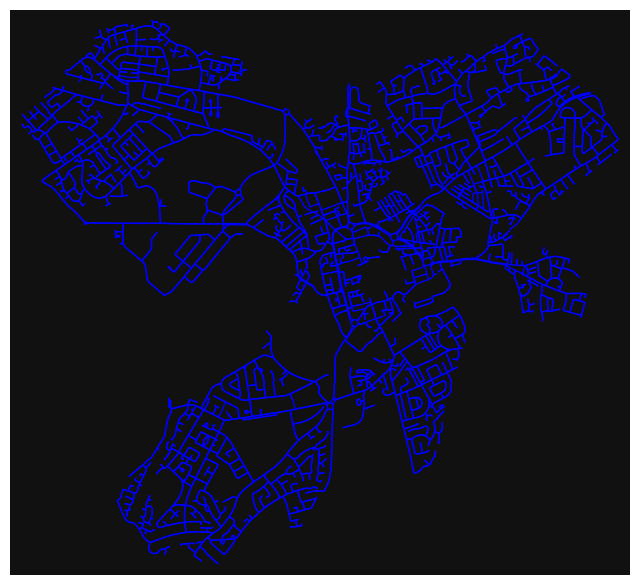

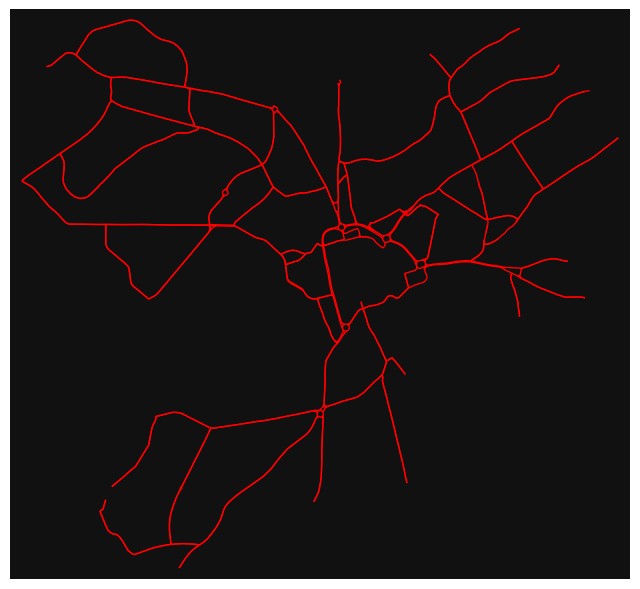

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [10]:
## plot the sparce graph to double check out boundary roads are correct 
ox.plot_graph(drive_g, edge_color='b', node_size=0, show=False)
ox.plot_graph(sparse_drive_g, edge_color='r', node_size=0, show=True)

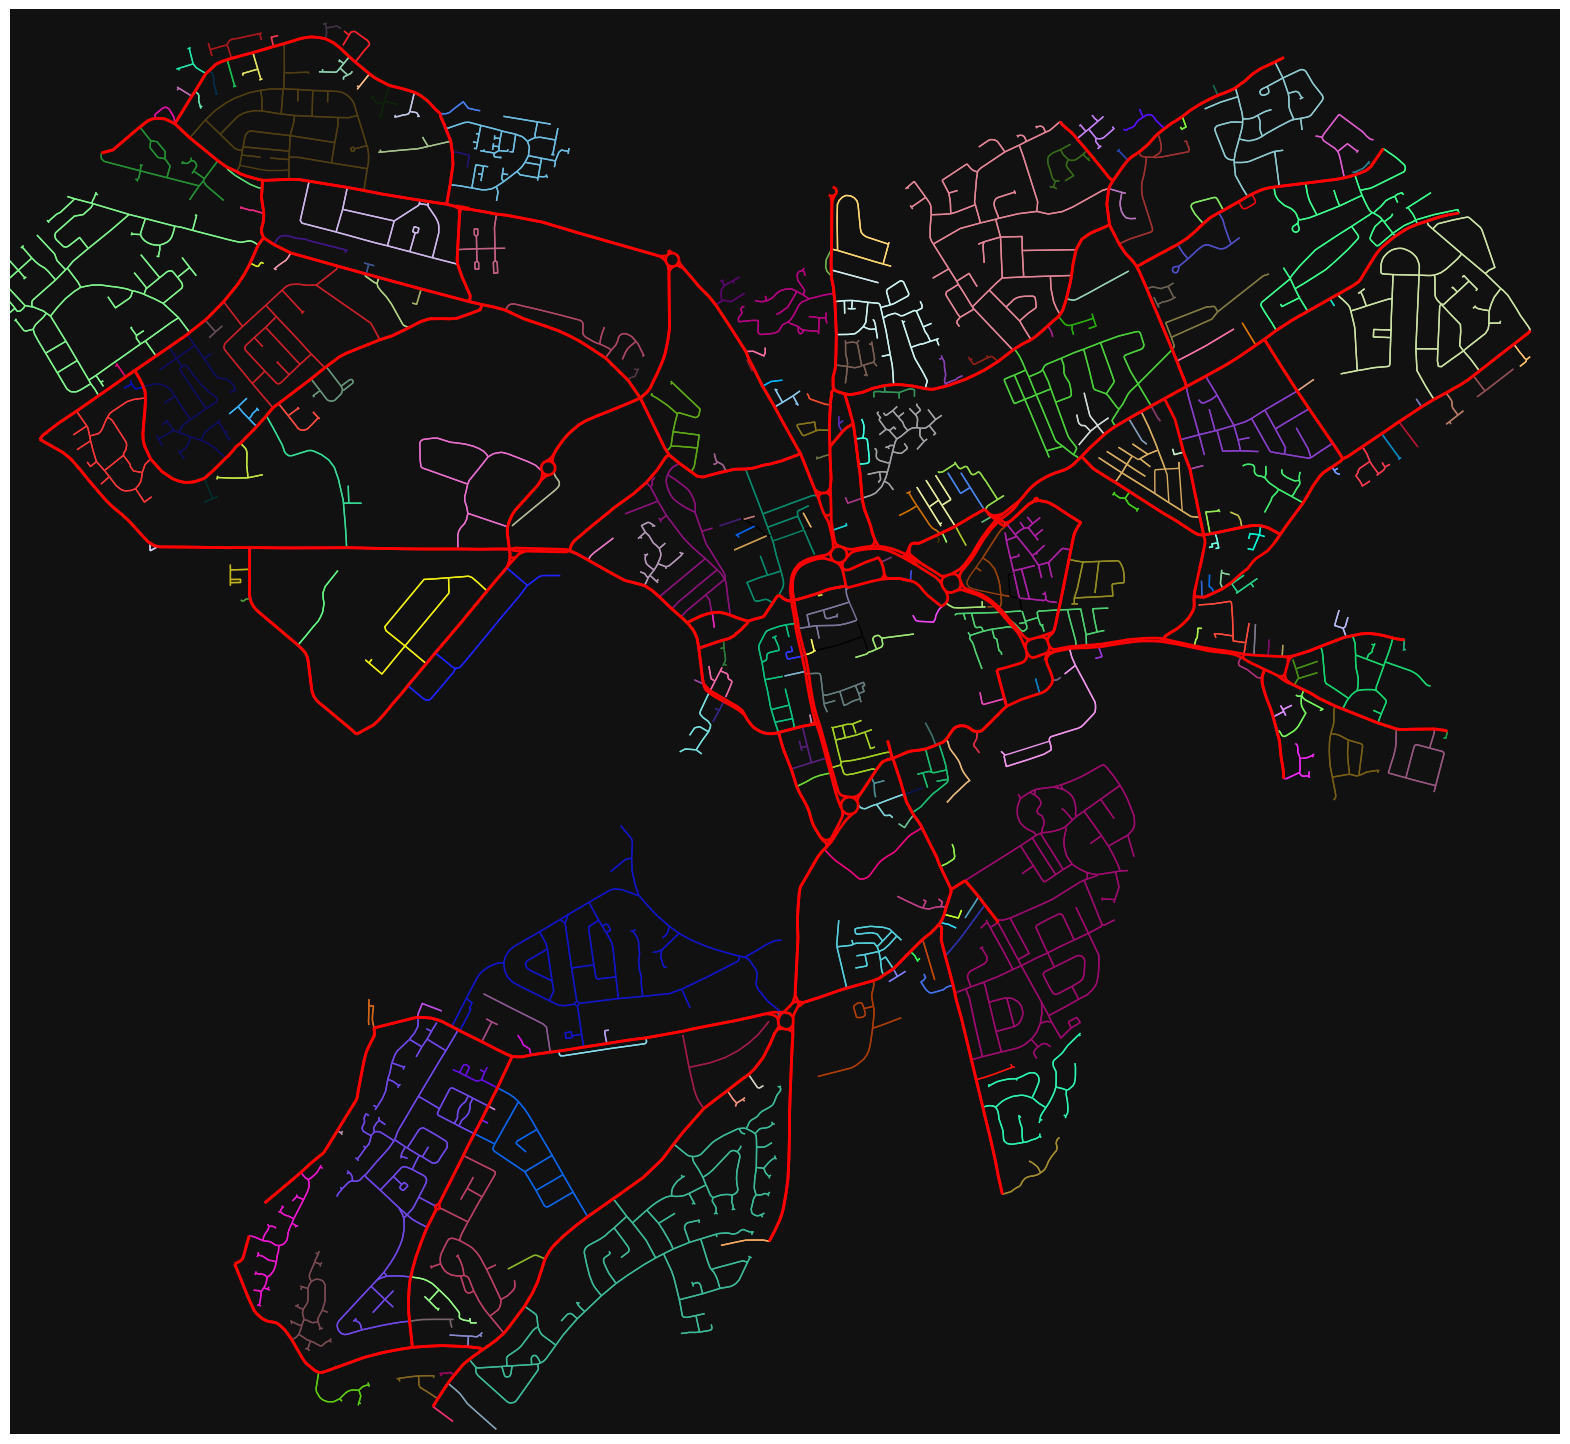

In [11]:
## create a partitioned network (using the full graph and the sparse graph)

# Make a copy of the original graph
drive_g_copy = drive_g.copy()

## Remove edges 
drive_g_copy.remove_edges_from(sparse_drive_g.edges)

## Remove nodes
# Convert nodes to strings
sparse_drive_nodes_str = [str(node) for node in sparse_drive_g.nodes]
drive_g_copy.remove_nodes_from(sparse_drive_nodes_str)

# clean nodes by removing isolated nodes from the graph
isolated_nodes = list(nx.isolates(drive_g_copy))
drive_g_copy.remove_nodes_from(isolated_nodes)


## partition the full graph, by removing the sparse graph from it.

# first nodes shared between sparse_drive_g and drive_g (these nodes are the connection between neighbourhoods and boundary roads)
shared_nodes = set(sparse_drive_g.nodes).intersection(drive_g_copy.nodes)


# we then need to remove nodes where junctions between two neighbourhood nodes and sparse graphs are present. 
# we do this by adding new nodes the end of edges which intersect with the sparse graph, to split these junctions up
# Initialize a counter to generate unique indices for new nodes
node_counter = Counter()
# Iterate through shared nodes
for shared_node in shared_nodes:
    # Find edges in drive_g connected to the shared node
    drive_g_edges = list(drive_g_copy.edges(shared_node, data=True, keys=True))

    # Find edges in sparse_drive_g connected to the shared node
    sparse_drive_g_edges = list(sparse_drive_g.edges(shared_node, data=True, keys=True))

    # Iterate through edges in drive_g connected to the shared node
    for u, v, key, data in drive_g_edges:
        # Check if the corresponding edge is not in sparse_drive_g
        if (u, v, key) not in sparse_drive_g_edges:
            # Create new end nodes for the edge in drive_g
            new_u = f"new_{u}" if u == shared_node else u
            new_v = f"new_{v}" if v == shared_node else v

            # Generate a unique index for each new node ID
            new_u_id = f"{new_u}_{key}_{node_counter[new_u]}" if new_u != u else new_u
            new_v_id = f"{new_v}_{key}_{node_counter[new_v]}" if new_v != v else new_v

            # Increment the counter for each new node
            node_counter[new_u] += 1
            node_counter[new_v] += 1

            # Add new nodes and update the edge
            drive_g_copy.add_node(new_u_id, **drive_g_copy.nodes[u])
            drive_g_copy.add_node(new_v_id, **drive_g_copy.nodes[v])

            drive_g_copy.add_edge(new_u_id, new_v_id, key=key, **data)

            # Check if the reverse edge already exists in drive_g_copy
            if not drive_g_copy.has_edge(new_v_id, new_u_id, key):
                # Create the reverse edge with new nodes
                drive_g_copy.add_edge(new_v_id, new_u_id, key=key, **data)

            # Disconnect the shared node from the new edge
            drive_g_copy.remove_edge(u, v, key)

    # Remove the shared node
    drive_g_copy.remove_node(shared_node)


# Find strongly connected components in the modified drive_g graph
drive_g_scc = list(nx.strongly_connected_components(drive_g_copy))

# Create a color mapping for edges in each strongly connected component using random colors
edge_colors = {}
for i, component in enumerate(drive_g_scc):
    color = (random.random(), random.random(), random.random())  # RGB tuple with random values
    for edge in drive_g_copy.edges:
        if edge[0] in component and edge[1] in component:
            edge_colors[edge] = color

# Plot the graph with edge colors and without nodes
fig, ax = ox.plot_graph(drive_g_copy, edge_color=[edge_colors.get(edge, (0, 0, 0)) for edge in drive_g_copy.edges], node_size=0, show=False, close=False, figsize=(20, 20))
ox.plot_graph(sparse_drive_g, ax=ax, edge_color='red', edge_linewidth=2, node_size=0, show=True)
#fig.show()

## add ssc index to each neighbourhood

# Create a mapping from nodes to their SCC index
node_scc_mapping = {node: i for i, scc in enumerate(drive_g_scc) for node in scc}

# Add SCC attribute to edges
for u, v, key, data in drive_g_copy.edges(keys=True, data=True):
    scc_index_u = node_scc_mapping.get(u, None)
    scc_index_v = node_scc_mapping.get(v, None)
    
    # Add the SCC index as an attribute to the edge
    drive_g_copy[u][v][key]['scc_index'] = scc_index_u if scc_index_u is not None else scc_index_v

## join neighbourhood mapping to orignial driving graph

# Add SCC index attribute to drive_g
for u, v, key, data in drive_g.edges(keys=True, data=True):
    scc_index_u = node_scc_mapping.get(u, None)
    scc_index_v = node_scc_mapping.get(v, None)
    
    # Add the SCC index as an attribute to the edge
    drive_g[u][v][key]['scc_index'] = scc_index_u if scc_index_u is not None else scc_index_v

In [12]:
## we can optionally plot this to check it looks correct

""" ## plot drive_g by neighbourhooods


# Create a color mapping for edges based on SCC index
scc_colors = {}
for u, v, key, data in drive_g.edges(keys=True, data=True):
    scc_index = data.get('scc_index')
    if scc_index is not None:
        if scc_index not in scc_colors:
            scc_colors[scc_index] = (random.random(), random.random(), random.random())  # RGB tuple with random values

# Plot the graph with edge colors based on SCC index
fig, ax = plt.subplots(figsize=(20, 20))
for u, v, key, data in drive_g.edges(keys=True, data=True):
    scc_index = data.get('scc_index')
    color = scc_colors.get(scc_index, (0, 0, 0))  # Default color if no SCC index or color mapping found
    x = [drive_g.nodes[u]['x'], drive_g.nodes[v]['x']]
    y = [drive_g.nodes[u]['y'], drive_g.nodes[v]['y']]
    ax.plot(x, y, color=color, linewidth=1)

# Plot sparse_drive_g on top of drive_g
ox.plot_graph(sparse_drive_g, ax=ax, edge_color='red', edge_linewidth=2, node_size=0)

plt.show()
 """

" ## plot drive_g by neighbourhooods\n\n\n# Create a color mapping for edges based on SCC index\nscc_colors = {}\nfor u, v, key, data in drive_g.edges(keys=True, data=True):\n    scc_index = data.get('scc_index')\n    if scc_index is not None:\n        if scc_index not in scc_colors:\n            scc_colors[scc_index] = (random.random(), random.random(), random.random())  # RGB tuple with random values\n\n# Plot the graph with edge colors based on SCC index\nfig, ax = plt.subplots(figsize=(20, 20))\nfor u, v, key, data in drive_g.edges(keys=True, data=True):\n    scc_index = data.get('scc_index')\n    color = scc_colors.get(scc_index, (0, 0, 0))  # Default color if no SCC index or color mapping found\n    x = [drive_g.nodes[u]['x'], drive_g.nodes[v]['x']]\n    y = [drive_g.nodes[u]['y'], drive_g.nodes[v]['y']]\n    ax.plot(x, y, color=color, linewidth=1)\n\n# Plot sparse_drive_g on top of drive_g\nox.plot_graph(sparse_drive_g, ax=ax, edge_color='red', edge_linewidth=2, node_size=0)\n\n

No path found between 8300561 and 7761331. Skipping...
No path found between 8300561 and 7761328. Skipping...
No path found between 8300569 and 7761331. Skipping...
No path found between 9095200 and 7761328. Skipping...
No path found between 2827743265 and 7761328. Skipping...
No path found between 2827743266 and 7761328. Skipping...
No path found between 3630145575 and 7761328. Skipping...
No path found between 8300589 and 7761331. Skipping...
No path found between 8300592 and 7761328. Skipping...
No path found between 9095222 and 7761331. Skipping...
No path found between 9095222 and 7761328. Skipping...
No path found between 8083511 and 7761328. Skipping...
No path found between 3065157690 and 7761331. Skipping...
No path found between 883132505 and 7761331. Skipping...
No path found between 9465987 and 7761331. Skipping...
No path found between 8091815 and 7761331. Skipping...
No path found between 8091816 and 7761328. Skipping...
No path found between 8091817 and 7761331. Skipping

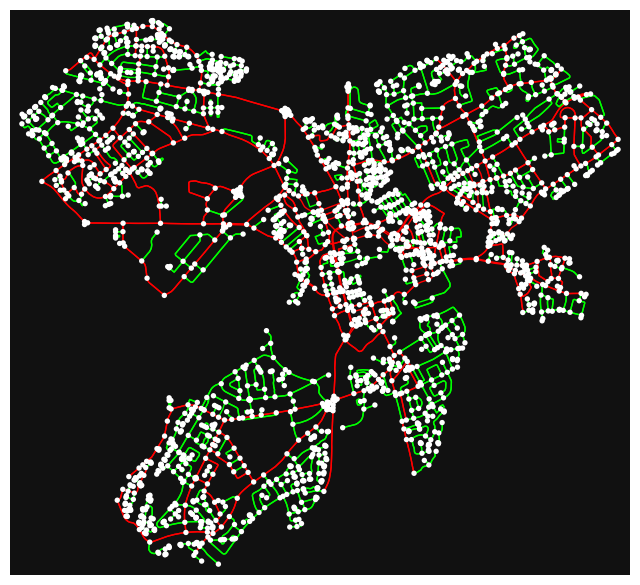

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<Axes: >

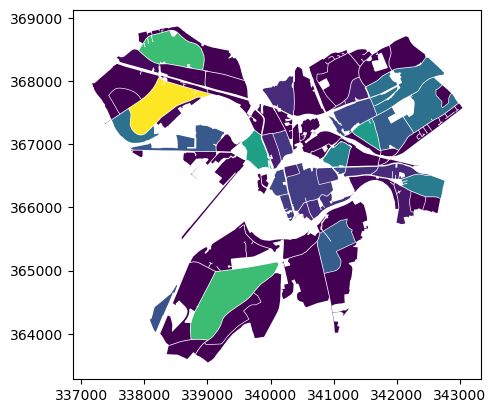

In [14]:
## now we move to finding the fastest paths. To save on computation time, we do not do an all pairs shortest path. Instead, we take a sample of random nodes per node. Change this value as suites.
## get random nodes


# Function to get random nodes present in both graphs for each node
def get_random_nodes_for_each(graph1, graph2, num_nodes=150):
    random_nodes_for_each = {}
    common_nodes = set(graph1.nodes()) & set(graph2.nodes())
    for node in common_nodes:
        neighbors = list(set(graph1.neighbors(node)) & set(graph2.neighbors(node)))
        if len(neighbors) >= num_nodes:
            random_neighbors = random.sample(neighbors, num_nodes)
        else:
            random_neighbors = neighbors + random.sample(list(common_nodes - set(neighbors)), num_nodes - len(neighbors))
        random_nodes_for_each[node] = random_neighbors
    return random_nodes_for_each

# Get random nodes for each common node
random_nodes_for_each = get_random_nodes_for_each(drive_g, sparse_drive_g)



## Find shortest paths 

# Convert the dictionary of nodes into a list of tuples
nodes_list = [(key, value) for key, values in random_nodes_for_each.items() for value in values]

# Find shortest paths and store them in a dictionary
shortest_paths = {}
for start_node, end_node in nodes_list:
    try:
        shortest_path = nx.shortest_path(drive_g, start_node, end_node, weight='travel_time')
        shortest_paths[(start_node, end_node)] = shortest_path
    except nx.NetworkXNoPath:
        print(f"No path found between {start_node} and {end_node}. Skipping...")



## find edges passed through

edges_passed_through = set()

for path in shortest_paths.values():
    # Pair consecutive nodes to create edges
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    
    # Check if each edge exists in the graph
    for edge in path_edges:
        if edge in drive_g.edges:
            edges_passed_through.add(edge)

# Convert the set of edges to a list if needed
edges_passed_through = list(edges_passed_through)

# give edges a rat_run value of either true or false
for u, v, data in drive_g.edges(data=True):
    if (u, v) in edges_passed_through or (v, u) in edges_passed_through:
        data['rat_run'] = True
    else:
        data['rat_run'] = False

edge_colors = ['#ff0000' if data.get('rat_run', False) else '#00ff00' for u, v, data in drive_g.edges(data=True)]
ox.plot_graph(drive_g, edge_color=edge_colors)

# Convert the NetworkX graph to a GeoDataFrame
drive_gdf_nodes, drive_gdf_edges = ox.graph_to_gdfs(drive_g)

drive_gdf_edges = drive_gdf_edges.to_crs(27700)
drive_gdf_nodes = drive_gdf_nodes.to_crs(27700)

# Filter drive_gdf_edges to only include edges with 'rat_run' = True
rat_run_edges = drive_gdf_edges[drive_gdf_edges['rat_run'] == True]

# Perform spatial join between neighbourhoods and rat_run_edges
join_result = gpd.sjoin(neighbourhoods, rat_run_edges, how='left', op='intersects')

# Group by neighbourhood index and count the number of rat_run edges in each
rat_run_edge_count = join_result.groupby(join_result.index)['ID'].count().reset_index(name='rat_run_edge_count')

# Group by neighbourhood index and count the number of rat_run edges in each
rat_run_edge_count = join_result.groupby(join_result.index)['ID'].count().reset_index(name='rat_run_edge_count')

# Join rat_run_edge_count with neighbourhoods based on index
neighbourhoods = neighbourhoods.join(rat_run_edge_count.set_index('index'))

neighbourhoods.plot(column='rat_run_edge_count')

Now we have our neighbourhoods which have rat runs going through them. We also have our raw rat runs. Optionally, we can export these to geopackages, using the code below:

In [ ]:
# export roads

# Step 1: Define a function to convert lists to strings
def convert_lists_to_strings(value):
    if isinstance(value, list):
        return str(value)
    return value

# Step 2: Apply the conversion function to each cell in the GeoDataFrame
drive_gdf_edges = drive_gdf_edges.applymap(convert_lists_to_strings)

file_path = r'C:\Users\b8008458\Documents\scratch_space\roads.gpkg'
drive_gdf_edges.to_file(file_path, driver='GPKG')

In [103]:
# export neighbourhoods
# Define the file path
file_path_neighbourhoods = r'C:\Users\b8008458\Documents\scratch_space\neighbourhoods_rat_runs.gpkg'

# Save the neighbourhoods GeoDataFrame to a GeoPackage
neighbourhoods.to_file(file_path_neighbourhoods, driver='GPKG')